# Item reactivation subsequent memory effects

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from bender_study import task
from bender_study import rsa

bids_dir = Path(os.environ['BENDER_BIDS']) / 'rawdata'
res_dir = Path(os.environ['BENDER_RESULTS'])
fig_dir = Path(os.environ['BENDER_FIGURES']) / 'plots'

react_dir = res_dir / 'batch' / 'glm' / 'study_stim2' / 'react'

In [2]:
# load BC study data with test performance
subjects = task.get_subjects('react')
dfs = [
    (
        task.load_merged_study_events(bids_dir, s)
        .sort_values('group')
        .query('pair_type == "BC"')
    ) for s in subjects
]

In [3]:
# load the pre-exposure to study representational 
# dissimilarity matrix for each ROI and subject
rois = ['aIFG', 'amPFC']
analyses = ['cat_react_item_sme2', 'cat_react_item_sme2']
clusters = ['rifg', 'ampfc']
suffix = 'dil1c'
roi_rdms = rsa.load_roi_rdms(
    react_dir, subjects, rois, analyses, clusters, suffix
)

## Item reactivation/suppression by AC test accuracy

In [4]:
stats = rsa.reactivation_stats_split(subjects, roi_rdms, dfs)

m = stats.groupby(['subject', 'roi', 'correct'])['item'].apply(
    lambda x: x.mean() if x.notna().all() else np.nan
).reset_index()
m['Inference'] = m['correct'].map({0: 'Incorrect', 1: 'Correct'})

In [5]:
groups = m.groupby(['roi', 'Inference'])['item']
groups.agg(['mean', 'sem'])

mean       sem
roi   Inference                    
aIFG  Correct    0.016782  0.004571
      Incorrect -0.036558  0.016048
amPFC Correct   -0.005345  0.005157
      Incorrect -0.055850  0.020860

In [6]:
groups.apply(pg.ttest, 0)

T  dof alternative     p-val          CI95%  \
roi   Inference                                                              
aIFG  Correct   T-test  3.671653   29   two-sided  0.000968   [0.01, 0.03]   
      Incorrect T-test -2.277991   27   two-sided  0.030861  [-0.07, -0.0]   
amPFC Correct   T-test -1.036474   29   two-sided  0.308547  [-0.02, 0.01]   
      Incorrect T-test -2.677401   27   two-sided  0.012467  [-0.1, -0.01]   

                         cohen-d    BF10     power  
roi   Inference                                     
aIFG  Correct   T-test  0.670349  34.101  0.943812  
      Incorrect T-test  0.430500   1.809  0.593509  
amPFC Correct   T-test  0.189233   0.317  0.170671  
      Incorrect T-test  0.505981   3.827  0.732775

In [7]:
groups.apply(pg.wilcoxon, np.zeros(30))

W-val alternative     p-val       RBC      CLES
roi   Inference                                                          
aIFG  Correct   Wilcoxon   85.0   two-sided  0.002498  0.634409  0.666667
      Incorrect Wilcoxon  115.0   two-sided  0.046316 -0.433498  0.392857
amPFC Correct   Wilcoxon  193.0   two-sided  0.422457 -0.169892  0.466667
      Incorrect Wilcoxon  113.0   two-sided  0.041546 -0.443350  0.392857

In [8]:
dark = sns.color_palette(
    [
        (1.0000, 0.2784, 0.5647),
        (0.4000, 0.4000, 0.4000),
    ]
)

dark

[(1.0, 0.2784, 0.5647), (0.4, 0.4, 0.4)]

In [9]:
light = sns.color_palette(
    [
        (1.0000, 0.5961, 0.8275),
        (0.8000, 0.8000, 0.8000),
    ]
)
light

[(1.0, 0.5961, 0.8275), (0.8, 0.8, 0.8)]

LINO NOT subset; don't know how to subset; dropped


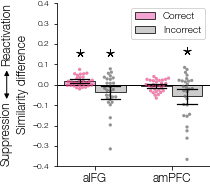

In [10]:
fig, ax = plt.subplots(figsize=(2.75, 3))
ax.set(ylim=(-.4, .4))
ax = statplot.plot_swarm_bar(
    data=m, 
    x='roi', 
    y='item', 
    hue='Inference',
    hue_order=['Correct', 'Incorrect'],
    dodge=True,
    sig_ind=[0, 1, 3],
    bar_kws=dict(capsize=.25),
    light=light,
    dark=dark,
    ax=ax,
)

# add annotation to help with interpretation
prop = dict(
    rotation='vertical', 
    xycoords='axes fraction',
    horizontalalignment='center',
    fontsize='large',
)
xoffset = -0.325
yoffset = 0.1
ax.annotate(
    'Reactivation', 
    xy=(xoffset, 1), 
    verticalalignment='top',
    **prop,
)
ax.annotate(
    'Suppression', 
    xy=(xoffset, 0), 
    verticalalignment='bottom',
    **prop,
)
ax.annotate(
    '', 
    xy=(xoffset, 0.5 - yoffset), 
    xytext=(xoffset, 0.5 + yoffset), 
    arrowprops=dict(arrowstyle="<|-|>", facecolor='k'),
    xycoords='axes fraction',
)

# plot line at zero
xlim = ax.get_xlim()
ax.hlines(0, *xlim, colors=['k']);
ax.set(xlim=xlim, ylabel='Similarity difference');
fig.savefig(fig_dir / 'cluster_sme_stats.pdf')

## Reactivation correlation

In [11]:
roi1, roi2 = rois
react_corr = rsa.item_roi_correlation(subjects, roi1, roi2, roi_rdms, dfs)

react_corr_mean = react_corr.groupby(['roi1', 'roi2', 'subject'])['slope'].apply(
    lambda x: x.mean() if x.notna().all() else np.nan
)

In [12]:
react_corr_mean.agg(['mean', 'sem'])

mean    0.141869
sem     0.025773
Name: slope, dtype: float64

In [13]:
react_corr_mean.groupby(['roi1', 'roi2']).apply(pg.ttest, 0)

,,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
roi1,roi2,,,,,,,,,
aIFG,amPFC,T-test,5.504496,29,two-sided,0.000006,"[0.09, 0.19]",1.004979,3251.608,0.999603


## Reactivation correlation by AC accuracy

In [14]:
corr = rsa.item_roi_correlation(
    subjects, roi1, roi2, roi_rdms, dfs, split_accuracy=True
)

corr_mean = corr.groupby(['correct', 'roi1', 'roi2', 'subject'])['slope'].apply(
    lambda x: x.mean() if x.notna().all() else np.nan
)

In [15]:
corr_mean.groupby(['correct', 'roi1', 'roi2']).agg(['mean', 'sem'])

,,,mean,sem
correct,roi1,roi2,,
0,aIFG,amPFC,0.160005,0.064510
1,aIFG,amPFC,0.128676,0.024553


In [16]:
sme = corr_mean.loc[1] - corr_mean.loc[0]
sme.groupby(['roi1', 'roi2']).agg(['mean', 'sem'])

,,mean,sem
roi1,roi2,,
aIFG,amPFC,-0.013319,0.063838


In [17]:
sme.groupby(['roi1', 'roi2']).apply(pg.ttest, 0)

,,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
roi1,roi2,,,,,,,,,
aIFG,amPFC,T-test,-0.208632,19,two-sided,0.836956,"[-0.15, 0.12]",0.046652,0.237,0.054517


In [18]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

mindstorm   : 0.9.0
pandas      : 1.4.3
matplotlib  : 3.5.1
numpy       : 1.22.3
pingouin    : 0.5.2
seaborn     : 0.11.2
bender_study: 0.1.0

